Iteration:  0  Loss:  262992540.0


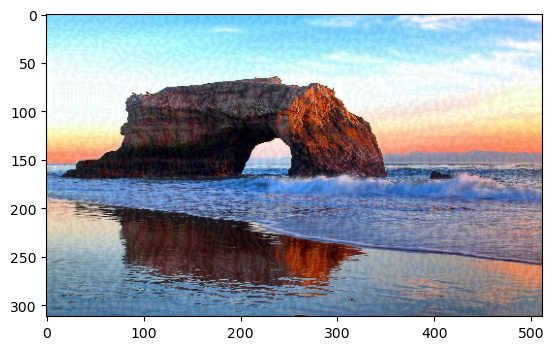

Iteration:  100  Loss:  9408712.0


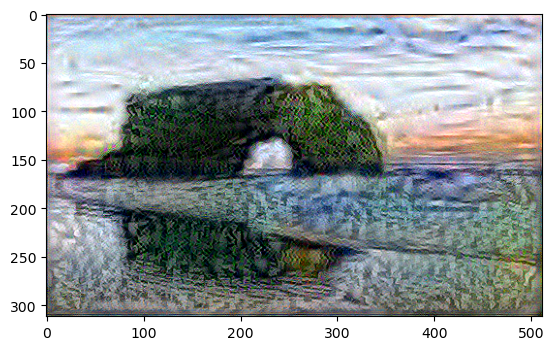

Iteration:  200  Loss:  2982460.2


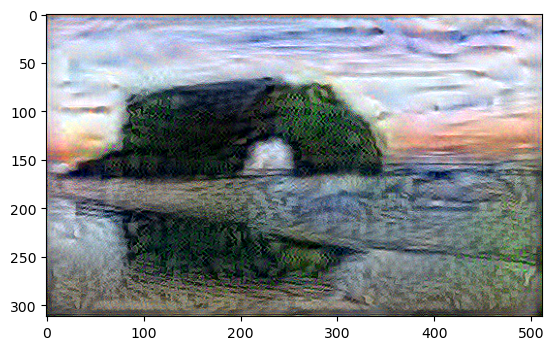

Iteration:  300  Loss:  1450409.1


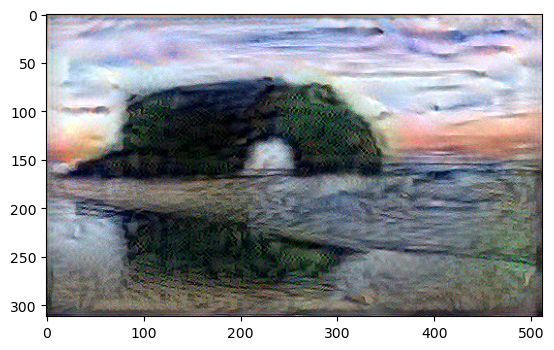

Iteration:  400  Loss:  913119.7


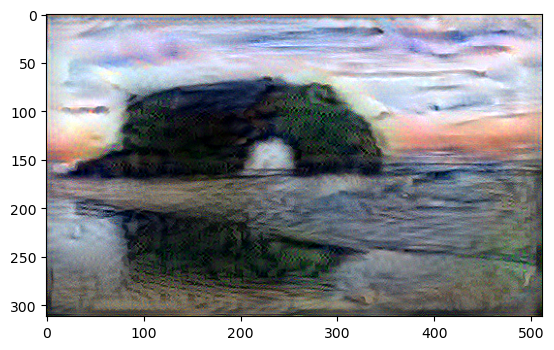

Iteration:  500  Loss:  654654.94


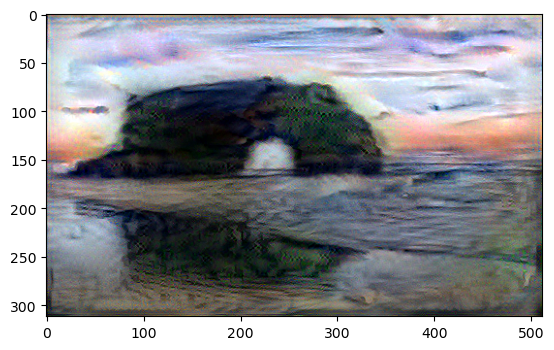

Iteration:  600  Loss:  501607.2


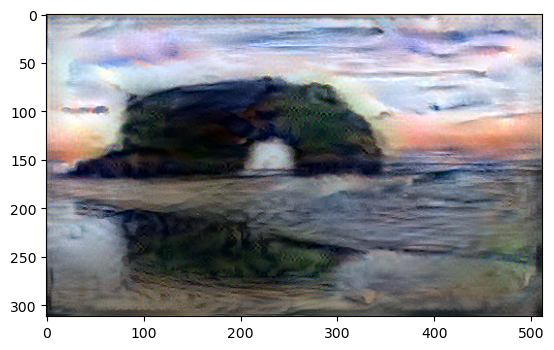

Iteration:  700  Loss:  404754.38


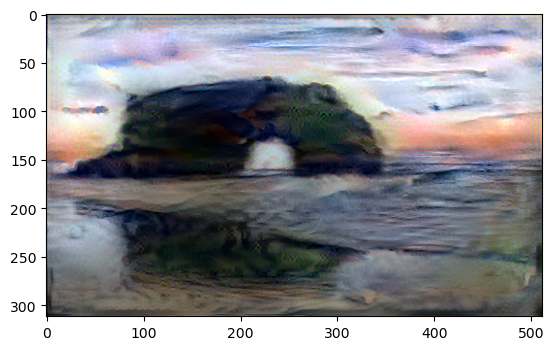

Iteration:  800  Loss:  341246.94


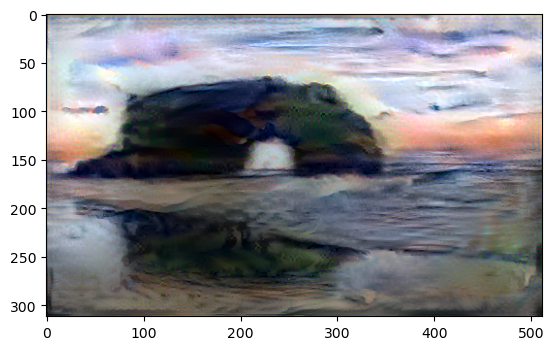

Iteration:  900  Loss:  298575.5


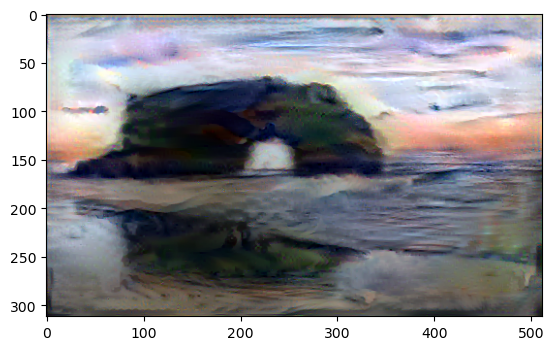

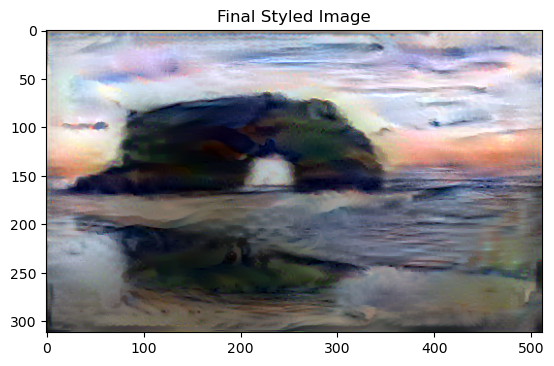

In [14]:
# Step 1: Environment Setup
# Step 2: Import Libraries
import tensorflow as tf
import numpy as np
from PIL import Image # Adds image processing capabilities to Python interpreter
import matplotlib.pyplot as plt # 2D graphics in Python programming

# Step 3: Prepare Images
def load_image(image_path):
    max_dim = 512 # Sets the maximum dimension
    img = tf.io.read_file(image_path) # io stands for Input/Output
    img = tf.image.decode_image(img, channels=3) # Decode the image into RGB format
    img = tf.image.convert_image_dtype(img, tf.float32) # Data types converted to floats, from[0, 255] to [0, 1]
    # Print(img) will show the pixels row by row
    shape = tf.cast(tf.shape(img)[:-1], tf.float32) # Get height and width, cast() convert int to float
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def show_image(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

# Load style and content images
content_image = load_image('content04.jpg')
style_image = load_image('style02.jpg')

# Step 4: Load Pre-trained VGG Model
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Choose layers to represent the style and content
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

# Step 5: Build the Model
def get_model():
    """ Creates a model that returns a list of style and content tensors. """
    # Load our model. We load pretrained VGG, trained on imagenet data
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    
    return tf.keras.Model(vgg.input, model_outputs)

# Define the gram_matrix for style features
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def total_variation_loss(image):
    return tf.reduce_sum(tf.image.total_variation(image))

# Loss functions
# def compute_loss(outputs, content_targets, style_targets):
#     style_outputs = outputs[:num_style_layers]
#     content_outputs = outputs[num_style_layers:]

#     style_weight = 0.01 # Default value = 0.01
#     content_weight = 100000 # Default value = 10000

#     style_score = 0
#     content_score = 0

#     # Sum of the style losses
#     weight_per_style_layer = 1.0 / float(num_style_layers)
#     for target_style, comb_style in zip(style_targets, style_outputs):
#         style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_matrix(comb_style) - target_style))

#     # Sum of the content losses
#     weight_per_content_layer = 1.0 / float(num_content_layers)
#     for target_content, comb_content in zip(content_targets, content_outputs):
#         content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content - target_content))

#     total_loss = style_weight * style_score + content_weight * content_score
#     return total_loss

# Loss functions with variation loss
def compute_loss(outputs, content_targets, style_targets, target_image, tv_weight=1e2):
    # Existing style and content loss calculation
    style_outputs = outputs[:num_style_layers]
    content_outputs = outputs[num_style_layers:]

    style_weight = 0.01
    content_weight = 100000

    style_score = 0
    content_score = 0

    # Sum of the style losses
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(style_targets, style_outputs):
        style_score += weight_per_style_layer * tf.reduce_mean(tf.square(gram_matrix(comb_style) - target_style))

    # Sum of the content losses
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_targets, content_outputs):
        content_score += weight_per_content_layer * tf.reduce_mean(tf.square(comb_content - target_content))

    # Compute total variation loss
    tv_loss = total_variation_loss(target_image)

    # Total loss is the sum of style, content, and total variation losses
    total_loss = (style_weight * style_score + 
                  content_weight * content_score +
                  tv_weight * tv_loss)

    return total_loss

# Step 6: Execute Style Transfer
# def run_style_transfer(content_path, style_path, num_iterations=2000):
#     model = get_model()
#     optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.99, epsilon=0.1)

#     # Load the initial target image
#     target_image = tf.Variable(load_image(content_path))
#     content_image = load_image(content_path)
#     style_image = load_image(style_path)

#     # Extract features
#     content_outputs = model(content_image * 255)
#     style_outputs = model(style_image * 255)

#     content_targets = [content_feature for content_feature in content_outputs[num_style_layers:]]
#     style_targets = [gram_matrix(style_feature) for style_feature in style_outputs[:num_style_layers]]

#     # Optimization loop
#     for i in range(num_iterations):
#         with tf.GradientTape() as tape:
#             outputs = model(target_image * 255)
#             loss = compute_loss(outputs, content_targets, style_targets)

#         grad = tape.gradient(loss, target_image) # Compute gradients of the loss with respect to the target image
#         optimizer.apply_gradients([(grad, target_image)]) # Apply the gradients to optimize the target image
#         target_image.assign(tf.clip_by_value(target_image, 0.0, 1.0)) # Make sure the value within the range of 0 to 1
        
#         if i % 10 == 0:
#             print("Iteration: ", i, " Loss: ", loss.numpy())
#             show_image(target_image.read_value())

#     # Show the final styled image
#     show_image(target_image.read_value(), title='Final Styled Image')

# Execute Style Transfer with variation loss
def run_style_transfer(content_path, style_path, num_iterations=500, tv_weight=1e2):
    model = get_model()
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.99, epsilon=0.1)

    target_image = tf.Variable(load_image(content_path))
    content_image = load_image(content_path)
    style_image = load_image(style_path)

    content_outputs = model(content_image * 255)
    style_outputs = model(style_image * 255)

    content_targets = [content_feature for content_feature in content_outputs[len(style_outputs):]]
    style_targets = [gram_matrix(style_feature) for style_feature in style_outputs]

    for i in range(num_iterations):
        with tf.GradientTape() as tape:
            outputs = model(target_image * 255)
            loss = compute_loss(outputs, content_targets, style_targets, target_image, tv_weight)

        grad = tape.gradient(loss, target_image)
        optimizer.apply_gradients([(grad, target_image)])
        target_image.assign(tf.clip_by_value(target_image, 0.0, 1.0))

        if i % 100 == 0:
            print("Iteration: ", i, " Loss: ", loss.numpy())
            show_image(target_image.read_value())

    show_image(target_image.read_value(), title='Final Styled Image')

# Run the style transfer
# run_style_transfer('content04.jpg', 'style03.jpg')

# Mild smoothing effect
run_style_transfer('content04.jpg', 'style02.jpg', num_iterations=1000, tv_weight=10)

# Moderate smoothing effect
# run_style_transfer('content04.jpg', 'style02.jpg', num_iterations=500, tv_weight=100)

# Strong smoothing effect
# run_style_transfer('content04.jpg', 'style02.jpg', num_iterations=500, tv_weight=1000)